In [1]:
# KOSPI200과 LIBOR1m를 이용한 고정비중 전략
# Monthly rebalancing 가정
# 측정기간(tau), 투자 시작일(stDateNum)을 바꿔가며 Back-test 가능

# 현재 디렉토리 확인
import os
os.getcwd()

# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
# ============================================================================
# Data 로딩 및 변수 정의
# ============================================================================
# 날짜 기준으로 오름차순 정렬된 Data 불러오기
data_excel = pd.ExcelFile('./Data/HW10_편정욱.xlsx') # read_excel과 차이= 엑셀 시트 여러개를 한번에 가져옴
data_df = data_excel.parse(sheet_name = 'Sheet1', header=1) # d / w(Fri) / m(EoM)
rawTime = data_df.iloc[:, 0].copy()     # Date
rawRisky = data_df.iloc[:, 1].copy()    # Risky asset price (K200)
rawExchange = data_df.iloc[:, 3].copy() # Exchange rate(KRW/USD)
rawRf = data_df.iloc[:, 4].copy()       # Risk-free rate (LIBOR1m, %)
numRaw = len(rawTime)

# Individual HP C/G (%)
rawCR1 = rawRisky.pct_change()*100 # (rawRisky / rawRisky.shift(1) - 1) * 100
rawCR2 = rawExchange.pct_change()*100  # (rawExchange / rawExchange.shift(1) - 1) * 100

# 무위험이자율 수익률 계산
rawLibor = (rawRf.shift(1)/12) # LIBOR1m의 정의를 고려하여 1칸 shift + 연율화 scaling
rawExLibor = ((1+rawLibor/100)*(1+rawCR2/100)-1)*100  # USD 이자를 KRW 이자로 환전하는 효과를 반영하여 KRW 수익률 계산

# Individual HPR (%, TR)
rawR1 = rawCR1.copy()
rawR2 = rawCR2 + rawExLibor

In [3]:
# ============================================================================
# Back Test 시작시점 기준으로 데이터 정리 (이 작업을 원하지 않으면 엑셀을 편집)
# ============================================================================
stDateNum = 19941228  # 19941228  # Back Test 시작일 (투자 시작일)
stDate = pd.to_datetime(str(stDateNum), format='%Y%m%d')
idx = np.argmin(np.abs(rawTime - stDate))  # Back Test 시작일에 해당하는 index

Time = rawTime[idx:].copy().reset_index(drop = True)  # 깊은 복사, index 초기화
R1 = rawR1[idx:].copy().reset_index(drop = True)
R2 = rawR2[idx:].copy().reset_index(drop = True)
numData = Time.shape[0]  # len(Data) or len(Data.index)

In [4]:
# ============================================================================
# 포트폴리오의 Value, DD 계산
# ============================================================================
# Weight
Weight = 0.5
W1 = pd.Series(data=Weight, index=rawTime)  # Risky asset 투자비중
W2 = 1 - W1  # Risk - free asset 투자비중

# Portfolio Value
Rp = pd.Series(np.zeros(numData)) # 수익률 (단위: %)
Vp = pd.Series(np.zeros(numData)) # Value
Vp[0] = 100 # 투자원금 = 100
for t in range(1, numData) : 
    Rp[t] = W1[t-1]*R1[t] + W2[t-1]*R2[t]   # HPR
    Vp[t] = Vp[t-1]*(1 + Rp[t]/100)         # Value
    
# Portfolio DD
MAXp = Vp.cummax()
DDp = (Vp/MAXp - 1) * 100  # 단위: %

In [5]:
# ============================================================================
# 벤치마크의 Value, DD 계산
# ============================================================================

# KOSPI200 벤치마크 Value, DD (투자 시작일 기준으로 표준화)
Vb1 = pd.Series(np.zeros(numData)) # Value
Vb1[0] = 100 # 투자원금 = 100
for t in range(1, numData) :             
    Vb1[t] = Vb1[t-1]*(1 + R1[t]/100)   

MAXb1 = Vb1.cummax()
DDb1 = (Vb1 / MAXb1 - 1) * 100  # 단위: %

# USD/KRW 벤치마크 Value, DD (투자 시작일 기준으로 표준화)
Vb2 = pd.Series(np.zeros(numData)) # Value
Vb2[0] = 100 # 투자원금 = 100
for t in range(1, numData) :             
    Vb2[t] = Vb2[t-1]*(1 + R2[t]/100)      

MAXb2 = Vb2.cummax()
DDb2 = (Vb2 / MAXb2 - 1) * 100  # 단위: %

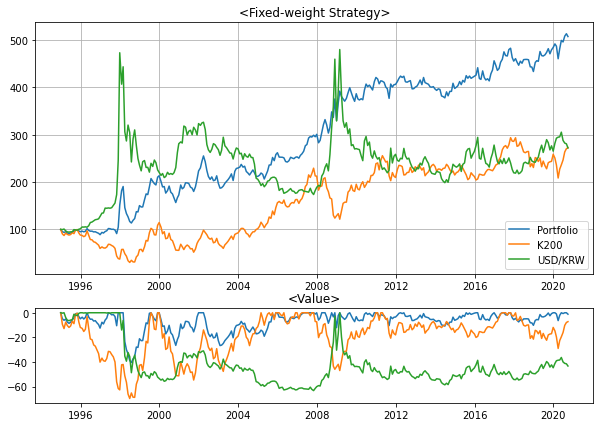

In [6]:
# ============================================================================
# 그래프 그리기
# ============================================================================

# Value와 MDD 그리기
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3],
                       width_ratios=[5])    # subplot의 크기를 서로 다르게 설정

ax0 = plt.subplot(gs[0])
ax0.plot(Time, Vp, label = 'Portfolio')
ax0.plot(Time, Vb1, label = 'K200')
ax0.plot(Time, Vb2, label = 'USD/KRW')
ax0.set_title('<Fixed-weight Strategy>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(Time, DDp, label = 'Fixed')
ax1.plot(Time, DDb1, label = 'K200')
ax1.plot(Time, DDb2, label = 'USD/KRW')
ax1.set_title('<Value>')
ax0.grid(True)
ax0.legend()

plt.show()

# 투자비중 결정

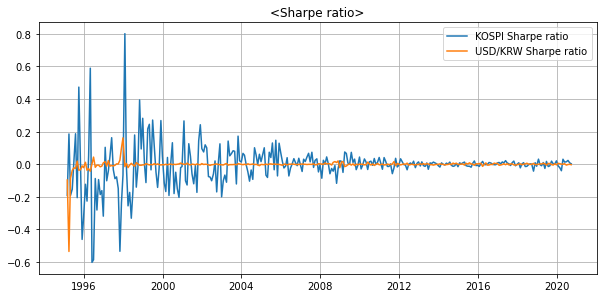

In [7]:
# ============================================================================
# 최종투자비중 결정
# ============================================================================

# 샤프지수 계산
KOSPIValue = rawRisky[idx:].copy().reset_index(drop = True)
USDKRWValue = rawExchange[idx:].copy().reset_index(drop = True)

# Rf는 CD금리로 사용
rawCD = data_df.iloc[:, 5].copy() 
RfCD = rawCD.shift(1)/12 # CD1m의 정의를 고려하여 1칸 shift + 연율화 scaling

rawKOSPIR = KOSPIValue.pct_change()*100
rawUSDKRWR = USDKRWValue.pct_change()*100

KOSPISharpe = pd.Series(np.zeros(numData))
USDKRWSharpe = pd.Series(np.zeros(numData))

for i in range(1,numData):
    KOSPISharpe[i] = (rawKOSPIR[i]-RfCD[i])/(KOSPIValue[:i].std()*np.sqrt(12))
    USDKRWSharpe[i] = (rawUSDKRWR[i]-RfCD[i])/(USDKRWValue[:i].std()*np.sqrt(12))

fig = plt.figure(figsize = (10, 7)) 

ax2 = plt.subplot(gs[0])
ax2.plot(Time, KOSPISharpe, label = 'KOSPI Sharpe ratio')
ax2.plot(Time, USDKRWSharpe, label = 'USD/KRW Sharpe ratio')
ax2.set_title('<Sharpe ratio>')
ax2.grid(True)
ax2.legend()
plt.show()

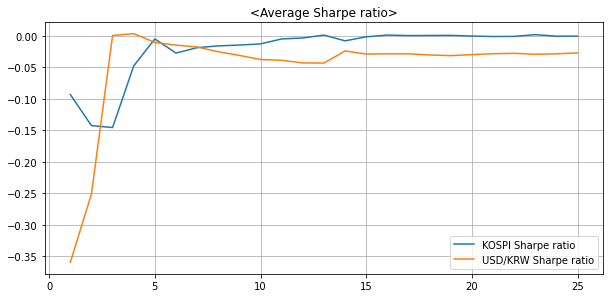

In [8]:
# 일별 샤프지수를 확인한 결과 꾸준하게 두 자산 중 꾸준하게 높은 지수를 보이는
# 자산이 없어 아래와 같은 방법으로 바꿈

# 주기별 샤프지수를 확인하기 위해 12개월 단위로 평균 표준편차 구하기
# (모든 기간을 평균하면 호황기의 퍼포먼스와 불황기의 퍼포먼스가 희석이될 우려가 있기 때문)

splitTime = 12

KOSPIRtn = pd.Series(np.zeros(int(numData/splitTime)))
USDKRWRtn = pd.Series(np.zeros(int(numData/splitTime)))

KOSPIVol = pd.Series(np.zeros(int(numData/splitTime)))
USDKRWVol = pd.Series(np.zeros(int(numData/splitTime)))

Rf = pd.Series(np.zeros(int(numData/splitTime)))


for t in range(splitTime, numData, splitTime):
    i = t/splitTime
    KOSPIRtn[i] = rawKOSPIR[:t].mean()
    USDKRWRtn[i] = rawUSDKRWR[:t].mean()
    
    KOSPIVol[i] = rawKOSPIR[:t].std() * np.sqrt(12)
    USDKRWVol[i] = rawUSDKRWR[:t].std() * np.sqrt(12)
    
    Rf[i] = RfCD[:t].mean()

KOSPISharpe = (KOSPIRtn-Rf)/KOSPIVol
USDKRWSharpe = (USDKRWRtn-Rf)/USDKRWVol

fig = plt.figure(figsize = (10, 7)) 

ax3 = plt.subplot(gs[0])
ax3.plot(KOSPISharpe, label = 'KOSPI Sharpe ratio')
ax3.plot(USDKRWSharpe, label = 'USD/KRW Sharpe ratio')
ax3.set_title('<Average Sharpe ratio>')
ax3.grid(True)
ax3.legend()
plt.show()

In [9]:
# 해당 지수 또한 Rf로 사용한 CD금리가 높아서 인지, 양의 값을 보이지 않음
# 두 샤프지수만 비교했을 때, 두 값의 차이는 전 기간을 걸쳐 보아도 0.05보다
# 작은 값을 지님

KOSPISharpe = (rawKOSPIR.mean()-Rf.mean())/(KOSPIValue.std()*np.sqrt(12))
USDKRWSharpe = (rawUSDKRWR.mean()-Rf.mean())/(USDKRWValue.std()*np.sqrt(12))

print("KOSPI200의 Sharpe ratio :",KOSPISharpe)
print("USD/KRW의 Sharpe ratio :",USDKRWSharpe)

KOSPI200의 Sharpe ratio : -0.0009133619225414061
USD/KRW의 Sharpe ratio : -0.0013119553925850201


In [10]:
# 최종적으로 투자 기간을 전부 활용한 샤프지수에서도 차이가 1% 보다 작은 값이며
# 이 말은 두 투자자산의 단위 위험에 대한 보상이 같다는 것을 알 수 있음
# 두 자산의 샤프지수가 비슷하면 두 자산에 한해서 분산효과를 최대로 내기 위해
# 동일 비중으로 투자를 하는 것이 가장 효율적일 것이라 결론
# ============================================================================
# 최종 비중을 사용한 포트폴리오의 Value, DD 계산
# ============================================================================
# Weight
Final_Weight = 0.5
W1 = pd.Series(data=Final_Weight, index=rawTime)  # Risky asset 투자비중
W2 = 1 - W1  # Risk - free asset 투자비중

# Portfolio Value
Rp = pd.Series(np.zeros(numData)) # 수익률 (단위: %)
Vp = pd.Series(np.zeros(numData)) # Value
Vp[0] = 100 # 투자원금 = 100
for t in range(1, numData) : 
    Rp[t] = W1[t-1]*R1[t] + W2[t-1]*R2[t]   # HPR
    Vp[t] = Vp[t-1]*(1 + Rp[t]/100)         # Value
    
# Portfolio DD
MAXp = Vp.cummax()
DDp = (Vp/MAXp - 1) * 100  # 단위: %

In [11]:
# ============================================================================
# 벤치마크의 Value, DD 계산
# ============================================================================

# KOSPI200 벤치마크 Value, DD (투자 시작일 기준으로 표준화)
Vb1 = pd.Series(np.zeros(numData)) # Value
Vb1[0] = 100 # 투자원금 = 100
for t in range(1, numData) :             
    Vb1[t] = Vb1[t-1]*(1 + R1[t]/100)   

MAXb1 = Vb1.cummax()
DDb1 = (Vb1 / MAXb1 - 1) * 100  # 단위: %

# USD/KRW 벤치마크 Value, DD (투자 시작일 기준으로 표준화)
Vb2 = pd.Series(np.zeros(numData)) # Value
Vb2[0] = 100 # 투자원금 = 100
for t in range(1, numData) :             
    Vb2[t] = Vb2[t-1]*(1 + R2[t]/100)      

MAXb2 = Vb2.cummax()
DDb2 = (Vb2 / MAXb2 - 1) * 100  # 단위: %

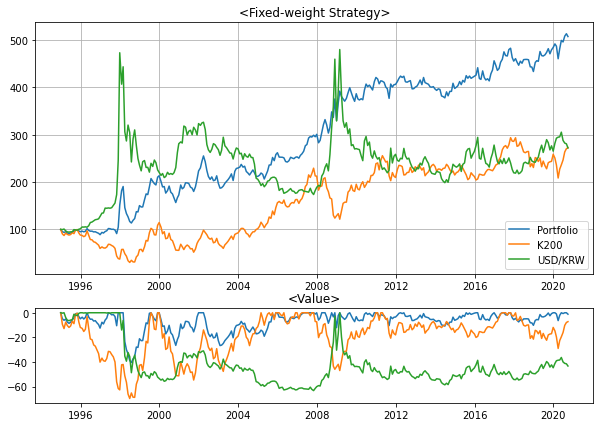

In [12]:
# ============================================================================
# 그래프 그리기
# ============================================================================

# Value와 MDD 그리기
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3],
                       width_ratios=[5])    # subplot의 크기를 서로 다르게 설정

ax0 = plt.subplot(gs[0])
ax0.plot(Time, Vp, label = 'Portfolio')
ax0.plot(Time, Vb1, label = 'K200')
ax0.plot(Time, Vb2, label = 'USD/KRW')
ax0.set_title('<Fixed-weight Strategy>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(Time, DDp, label = 'Fixed')
ax1.plot(Time, DDb1, label = 'K200')
ax1.plot(Time, DDb2, label = 'USD/KRW')
ax1.set_title('<Value>')
ax0.grid(True)
ax0.legend()

plt.show()